# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
from ema_workbench import (Model, Policy, RealParameter, ScalarOutcome, perform_experiments) # Policy import toegevoegd
from lakemodel_function import lake_problem #andere importfuctie toegevoegd

model = Model('LakeModel', function=lake_problem)

model.uncertainties = [RealParameter("mean", 0.01, 0.05),
                       RealParameter("stdev", 0.001, 0.005),
                       RealParameter("b", 0.1, 0.45),
                       RealParameter("q", 2, 4.5),
                       RealParameter("delta", 0.93, 0.99)]

model.levers = [RealParameter((str('l')+str(i)), 0, 0.1) for i in range(100)]# Voor iedere tijdstap een andere value --- Met str(l)
# Q&A example: model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(100)]

model.outcomes = [ScalarOutcome('max_P'), #alle vier outcomes uit de py file
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

from ema_workbench import (MultiprocessingEvaluator, ema_logging)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [2]:
experiments = experiments.drop([experiments.columns[i] for i in range(5, 105)], axis='columns')

In [3]:
import pandas as pd
import numpy as np
outcomes = pd.DataFrame(outcomes)
#outcomes = outcomes.sort_values('reliability')
outcomes.loc[outcomes['reliability'] <= np.percentile(outcomes['reliability'],10), '<10'] = 1
outcomes.loc[outcomes['reliability'] > np.percentile(outcomes['reliability'],10), '<10'] = 0
outcome_interest = outcomes['<10']

In [5]:
from ema_workbench.analysis import prim

prim_alg = prim.Prim(experiments, outcome_interest, threshold=0.7, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 796 cases of interest
[MainProcess/INFO] mean: 0.7966417910447762, mass: 0.0536, coverage: 0.5364321608040201, density: 0.7966417910447762 restricted_dimensions: 3


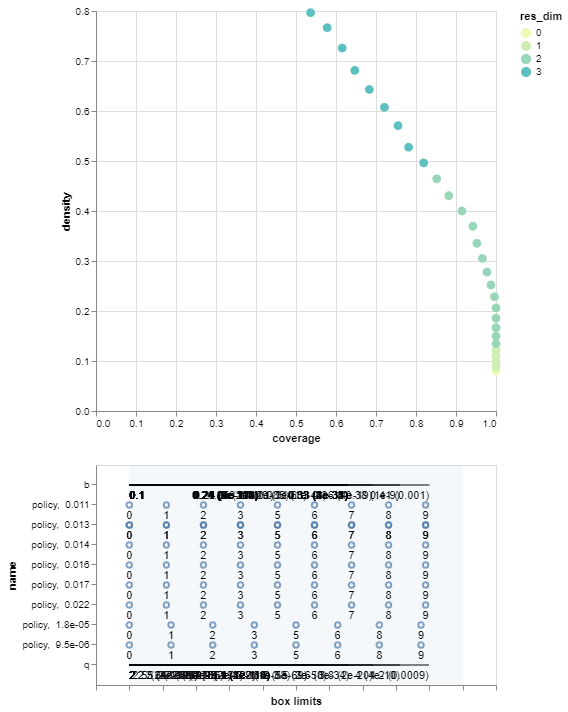

In [6]:
box1.inspect_tradeoff()

coverage    0.536432
density     0.796642
id                27
mass          0.0536
mean        0.796642
res_dim            3
Name: 27, dtype: object

                          box 27                            \
                             min                       max   
q                        2.00175                   2.47188   
b                       0.100278                  0.235362   
policy  {0, 1, 2, 3, 5, 6, 8, 9}  {0, 1, 2, 3, 5, 6, 8, 9}   

                                         
                              qp values  
q       [-1.0, 1.7625828067999095e-182]  
b       [-1.0, 2.2838261669840054e-108]  
policy    [9.537411598743467e-06, -1.0]  



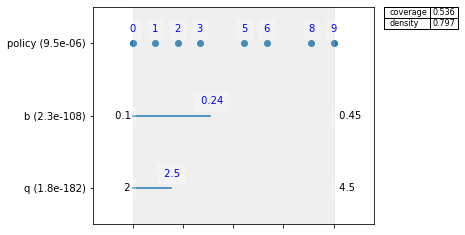

In [7]:
import matplotlib.pyplot as plt

box1.inspect(27)
box1.inspect(27, style='graph')
plt.show()

policy [0, 1, 2, 3, 5, 6, 8, 9, 4, 7]


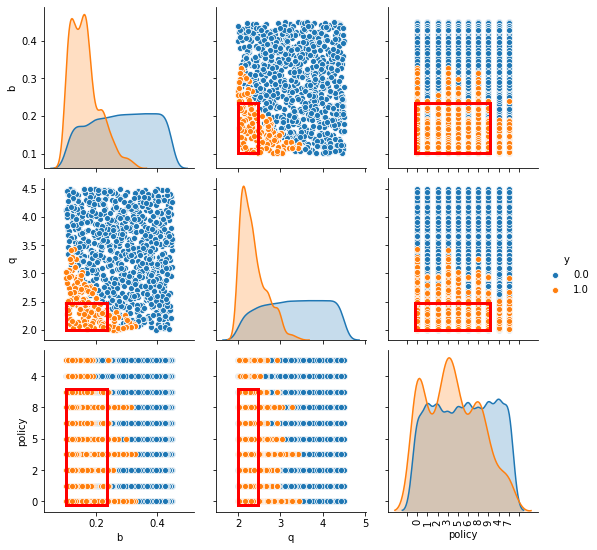

In [8]:
box1.select(27)
fig = box1.show_pairs_scatter()
plt.show()

In [9]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 9464 points remaining, containing 369 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.3719412724306688, returning dump box


## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?